In [1]:
import numpy as np
import scipy.constants as constants
import matplotlib.pyplot as plt
import matplotlib
import os

import detailedbalance as db

font = {'size' : 22}

matplotlib.rc('font',**font)
%matplotlib inline

In [2]:
# Just some constants for the upcoming math
c = constants.value('speed of light in vacuum')
h = constants.value('Planck constant in eV s')
e = constants.value('elementary charge')
k = constants.value('Boltzmann constant in eV/K')

pi = 3.1415

# Globals
Tcell = 300  # Kelvin
# Energy Gap
Egap = 1.1  #electron volts

r_earth = 6e6
r_sun = 6.95e8
d_sun = 1.50e11

In [21]:
E_ph = np.arange(0.01, 10,0.01) 
E_ph = np.flip(E_ph,0)

E_gaps = np.arange(0.3, 5,0.01) 
E_gaps = np.flip(E_gaps,0)

sourcetype = 0 

constants = {}

# sourcetype 1 for sun and 0 for full angle. This should perhaps be combined with the max_eff_temp function
if(sourcetype):
    #Sun
    constants['Temp'] = 5750
    constants['solidangle'] = db.solid_angle_sun(r_earth,d_sun)
    constants['emitterarea'] = 4*pi*r_sun**2
    constants['absorberarea'] = pi*r_earth**2
else:
    #Custom
    constants['Temp'] = 1500
    constants['solidangle'] = 2*pi
    constants['emitterarea'] = 1
    constants['absorberarea'] = 1
    
#constants['emissivity'] = db.gen_emissivity(0.1,1,1.1,E_ph)
constants['emissivity'] = db.lor_emissivity(0,1,3,0.001,E_ph)
   
#BB = db.gen_spectrum(E_ph,constants)

BB = db.gen_spectrum_lor(E_ph,0,1,1.12,0.001)


#check integrated irradiance is ~1kW/m^2
integrate = -np.trapz(BB[:,1],BB[:,0] )
print(integrate)

#BB[:,1] = BB[:,1]/integrate
BB[:,1] = BB[:,1]*1000000000000000

integrate = -np.trapz(BB[:,1],BB[:,0] )
print(integrate)


BB_ph = db.power_to_photons(BB)

print(db.stephan(5750)*4*pi*r_sun**2)

0.010325828662491711
10325828662491.71
3.762263521545546e+26


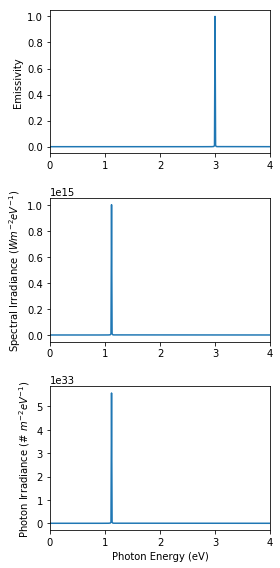

In [22]:
w,h =plt.figaspect(2) 
fig, ax = plt.subplots(3,1,figsize = (w,h) )
ax[0].plot(E_ph,constants['emissivity'])
ax[0].set_xlim(0,4)
ax[0].set_ylabel('Emissivity')

ax[1].plot(BB[:,0],BB[:,1] )
ax[1].set_xlim(0,4)
ax[1].set_ylabel('Spectral Irradiance ($Wm^{-2}eV^{-1}$)')

ax[2].plot(BB_ph[:,0],BB_ph[:,1] )
ax[2].set_xlim(0,4)
ax[2].set_ylabel('Photon Irradiance (# $m^{-2}eV^{-1}$)')
plt.xlabel('Photon Energy (eV)')

plt.tight_layout()

In [26]:
print('For a cell with bandgap %.2f eV' % Egap)
print('max power %.2f' % db.max_power(Egap, BB_ph) )
print('Irradiance %.2f' % db.int_irr(Egap, BB_ph ))
print('Ideal efficiency is {:.4}%'.format(db.max_eff(Egap, BB_ph)*100))

For a cell with bandgap 1.10 eV
max power 12204590066217.29
Irradiance 10325828662491.71
Ideal efficiency is 118.2%


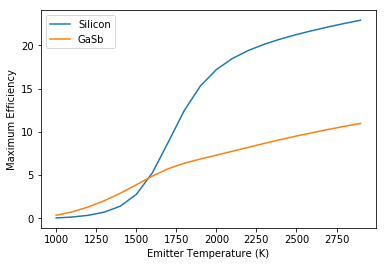

In [6]:
#generate multiple blackbody spectra


max_eff_all_Si, max_eff_all_GaSb, max_pow_all_Si,max_pow_all_GaSb = db.max_eff_temp(E_ph,1000,3000,100, constants)
#spectra_ph_all


ln1 = plt.plot(max_eff_all_Si)

ln2 = plt.plot(max_eff_all_GaSb)
lns = ln1 + ln2
plt.xlabel('Emitter Temperature (K)')
plt.ylabel('Maximum Efficiency')
plt.legend(lns, ('Silicon','GaSb'))
#plt.legend(max_eff_all_Si,'Si')

Text(0,0.5,'Maximum Power (W/m^2)')

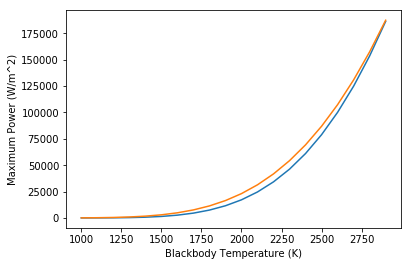

In [39]:
plt.plot(max_pow_all_Si)

plt.plot(max_pow_all_GaSb)
plt.xlabel('Blackbody Temperature (K)')
plt.ylabel('Maximum Power (W/m^2)')

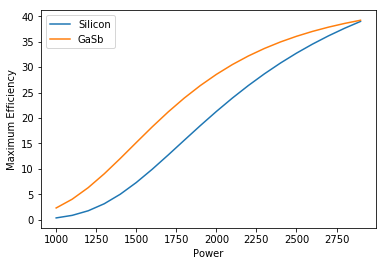

In [40]:
#generate multiple blackbody spectra now with the solid angle set to half 

import pandas as pd

max_eff_all_Si_pow, max_eff_all_GaSb_pow, max_pow_all_Si_pow,max_pow_all_GaSb_pow = db.max_eff_power(E_ph,constants)
    
ln1 = plt.plot(max_eff_all_Si)

ln2 = plt.plot(max_eff_all_GaSb)
lns = ln1 + ln2
plt.xlabel('Power')
plt.ylabel('Maximum Efficiency')
plt.legend(lns, ('Silicon','GaSb'))

Text(0,0.5,'Maximum Power (W/m^2)')

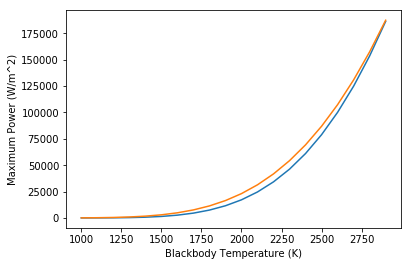

In [41]:
plt.plot(max_pow_all_Si)

plt.plot(max_pow_all_GaSb)
plt.xlabel('Blackbody Temperature (K)')
plt.ylabel('Maximum Power (W/m^2)')



In [42]:
print("Silicon cells")

print("efficiency " , max_eff_all_Si[2500])

print("power ", max_pow_all_Si[2500])
print("stephan ", db.stephan(2500))

print ("efficency from stephan" , max_pow_all_Si[2500]/db.stephan(2500)*100)

Silicon cells
efficiency  32.74206808923115
power  78920.31196373503
stephan  2214987.109375
efficency from stephan 3.5630145037730663


In [43]:
print("GaSb cells")


print("efficiency " , max_eff_all_GaSb[2500])

print("power ", max_pow_all_GaSb[2500])
print("stephan ", db.stephan(2500))

print ("efficency from stephan" , max_pow_all_GaSb[2500]/db.stephan(2500)*100)

GaSb cells
efficiency  36.06167298701365
power  86921.76909269093
stephan  2214987.109375
efficency from stephan 3.9242562055910803


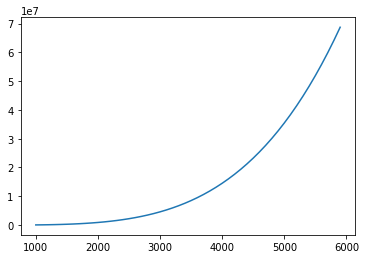

In [27]:
Temp = np.arange(1000.0, 6000.0,100.0)
Rad = np.copy(Temp)

for i in range(len(Temp)):
    Rad[i] = db.stephan(Temp[i])

plt.plot(Temp,Rad)

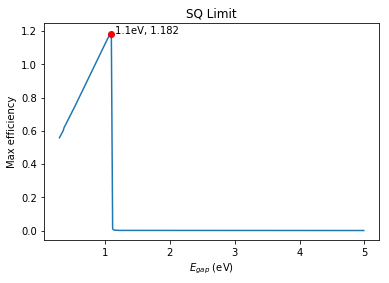

In [28]:
db.sq_limit_plot(BB_ph,E_gaps)

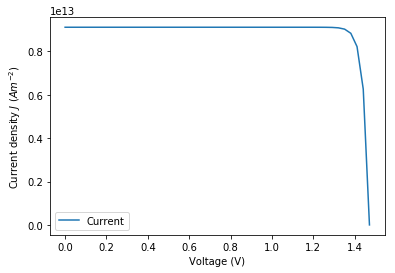

In [29]:
db.iv_curve_plot(1.1, BB_ph)

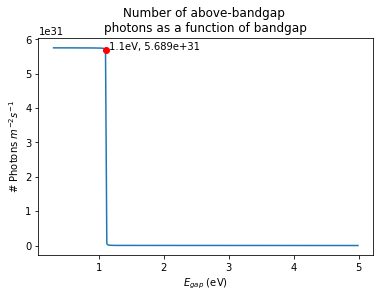

In [30]:
db.photons_above_bandgap_plot(BB_ph,E_gaps)

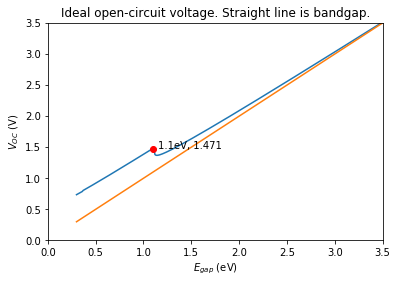

In [31]:
db.ideal_voc_plot(BB_ph,E_gaps)

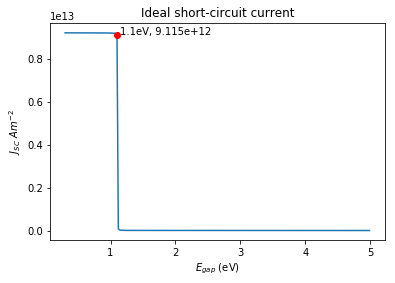

In [32]:
db.ideal_jsc_plot(BB_ph,E_gaps)

In [33]:
# For an ideal solar cell these will be
print('A material with a bandgap of %.2f will have an:' % Egap)
print('Ideal short circuit current: ', db.jsc(Egap, BB_ph), 'A/m^2')
print('Ideal open circuit  voltage: ', db.voc(Egap, BB_ph), 'V')


#watch out for minus 1

A material with a bandgap of 1.10 will have an:
Ideal short circuit current:  9114860487721.434 A/m^2
Ideal open circuit  voltage:  1.4714190404923402 V
